# OWL Win Predictor Data Processing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import datetime
import pickle
from joblib import dump, load 
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
import math
import altair as alt

In [2]:
# Calculate different number of combinations
combos_top5 = 0
for i in range(8,13):
    combos =  math.factorial(32)/ (math.factorial(i) * math.factorial(32-i))
    combos_top5 = combos_top5 + combos
combos_top5

457896660.0

In [3]:
# 2020 ruleset
tanks =  math.factorial(8)/ (math.factorial(2) * math.factorial(6))
dps = math.factorial(17)/ (math.factorial(2) * math.factorial(15))
support = math.factorial(7)/ (math.factorial(2) * math.factorial(5))

total_combos_no_swaps = tanks * dps * support
total_combos_no_swaps

79968.0

## Reading in player data

In [4]:
# map(function,iterable) -> read csv in each phs folder and assign to one dataframe
player_stats_all = pd.concat(map(pd.read_csv, glob.glob('datasets/phs*/*.csv')))
player_stats_all.head()

,start_time,match_id,stage,map_type,map_name,player,team,stat_name,hero,stat_amount
0,7/12/2018 0:19,13121,Overwatch League Inaugural Season Championship,PAYLOAD,Dorado,Gamsu,Boston Uprising,All Damage Done,All Heroes,10677.179340
1,7/12/2018 0:19,13121,Overwatch League Inaugural Season Championship,PAYLOAD,Dorado,Gamsu,Boston Uprising,Assists,All Heroes,10.000000
2,7/12/2018 0:19,13121,Overwatch League Inaugural Season Championship,PAYLOAD,Dorado,Gamsu,Boston Uprising,Average Time Alive,All Heroes,60.004185
3,7/12/2018 0:19,13121,Overwatch League Inaugural Season Championship,PAYLOAD,Dorado,Gamsu,Boston Uprising,Barrier Damage Done,All Heroes,4868.578228
4,7/12/2018 0:19,13121,Overwatch League Inaugural Season Championship,PAYLOAD,Dorado,Gamsu,Boston Uprising,Damage - Quick Melee,All Heroes,304.000000


In [6]:
# Resets index and drops the new row it makes
player_stats_all.reset_index(drop = True, inplace = True)
player_stats_all

,start_time,match_id,stage,map_type,map_name,player,team,stat_name,hero,stat_amount
0,7/12/2018 0:19,13121,Overwatch League Inaugural Season Championship,PAYLOAD,Dorado,Gamsu,Boston Uprising,All Damage Done,All Heroes,10677.179340
1,7/12/2018 0:19,13121,Overwatch League Inaugural Season Championship,PAYLOAD,Dorado,Gamsu,Boston Uprising,Assists,All Heroes,10.000000
2,7/12/2018 0:19,13121,Overwatch League Inaugural Season Championship,PAYLOAD,Dorado,Gamsu,Boston Uprising,Average Time Alive,All Heroes,60.004185
3,7/12/2018 0:19,13121,Overwatch League Inaugural Season Championship,PAYLOAD,Dorado,Gamsu,Boston Uprising,Barrier Damage Done,All Heroes,4868.578228
4,7/12/2018 0:19,13121,Overwatch League Inaugural Season Championship,PAYLOAD,Dorado,Gamsu,Boston Uprising,Damage - Quick Melee,All Heroes,304.000000
...,...,...,...,...,...,...,...,...,...,...
4018230,2021-04-25 22:40:45,37219,OWL 2021,HYBRID,Blizzard World,MAG,Washington Justice,Time Holding Ultimate,Wrecking Ball,37.723001
4018231,2021-04-25 22:40:45,37219,OWL 2021,HYBRID,Blizzard World,MAG,Washington Justice,Time Played,Wrecking Ball,300.753693
4018232,2021-04-25 22:40:45,37219,OWL 2021,HYBRID,Blizzard World,MAG,Washington Justice,Ultimates Earned - Fractional,Wrecking Ball,1.915191
4018233,2021-04-25 22:40:45,37219,OWL 2021,HYBRID,Blizzard World,MAG,Washington Justice,Ultimates Used,Wrecking Ball,1.000000


In [7]:
# Creates a year column and converts round_start_time to a datetime object, then extracts the year
player_stats_all['year'] = pd.to_datetime(player_stats_all['start_time'])
player_stats_all['year'] = pd.DatetimeIndex(player_stats_all["year"]).year

In [8]:
# Drops columns I will not be using
player_stats_all.drop(["start_time","stage", "map_type","stat_name", "stat_amount"], inplace = True, axis = 1)
player_stats_all = player_stats_all[player_stats_all.hero != "All Heroes"]

# sorts by match_id in ascending order and resets the index
player_stats_all = player_stats_all.sort_values(by = ["match_id", "map_name", "team" ], ascending = True)

#drops duplicate rows
player_stats_all = player_stats_all.drop_duplicates(subset = ["match_id", "map_name", "team", "hero"])

player_stats_all.reset_index(drop = True, inplace = True)
player_stats_all

,match_id,map_name,player,team,hero,year
0,10223,Dorado,Agilities,Los Angeles Valiant,Genji,2018
1,10223,Dorado,Envy,Los Angeles Valiant,D.Va,2018
2,10223,Dorado,Fate,Los Angeles Valiant,Winston,2018
3,10223,Dorado,KariV,Los Angeles Valiant,Mercy,2018
4,10223,Dorado,SoOn,Los Angeles Valiant,Tracer,2018
...,...,...,...,...,...,...
83248,37256,Temple of Anubis,LIP,Shanghai Dragons,Widowmaker,2021
83249,37256,Temple of Anubis,LeeJaeGon,Shanghai Dragons,Brigitte,2021
83250,37256,Temple of Anubis,LeeJaeGon,Shanghai Dragons,Lúcio,2021
83251,37256,Temple of Anubis,LeeJaeGon,Shanghai Dragons,Mercy,2021


## Read in map data

In [9]:
map_stats = pd.read_csv("datasets\match_map_stats.csv")

# Add the year column
map_stats['year'] = pd.to_datetime(map_stats['round_start_time'])
map_stats['year'] = pd.DatetimeIndex(map_stats["year"]).year

In [10]:
# filters down to needed columns and drops duplicate maps per match_id
map_stats = map_stats.filter(["match_id", "match_winner", "map_winner", "map_loser", "map_name","year"], axis = 1)
map_stats = map_stats.drop_duplicates(subset = ["match_id", "map_name"])

## Merge player stats and map stats

In [11]:
# Merges map stats and player stats with an outer join on the keys match_id, map_name, and year.
merge_all = pd.merge(map_stats, player_stats_all, how = "outer", on = ["match_id", "map_name", "year"])

# Sorts the values by match_id, map_name, and team
merge_all = merge_all.sort_values(by = ["match_id", "map_name", "team" ], ascending = True)

# Creates a match_win and map_win column. 
# It compares the team on the each row to the declareed winner from the map stat files.
# I made them strings so the categories were clear on the classifiers.
 
merge_all.loc[merge_all["match_winner"] == merge_all["team"], 'match_win'] = "win"
merge_all.loc[merge_all["match_winner"] != merge_all["team"], 'match_win'] = "lose"

merge_all.loc[merge_all["map_winner"] == merge_all["team"], 'map_win'] = "win"
merge_all.loc[merge_all["map_winner"] != merge_all["team"], 'map_win'] = "lose"

# Filters to only the listes columns.
merge_all = merge_all.filter(["match_id", "map_name","player", "team", "hero", "match_win" , "map_win", "year"])

# Drops rows without complete data. There was incomplete data on certain hero usage in games, 
# and there is no real way to find out without reviewing the match.
merge_all.dropna(axis = 0, how = 'any', inplace = True)

# Prints to csv with index removed
merge_all.to_csv("filteredData/all_merged_cat.csv", index = False)
merge_all

,match_id,map_name,player,team,hero,match_win,map_win,year
0,10223,Dorado,Agilities,Los Angeles Valiant,Genji,win,win,2018.0
1,10223,Dorado,Envy,Los Angeles Valiant,D.Va,win,win,2018.0
2,10223,Dorado,Fate,Los Angeles Valiant,Winston,win,win,2018.0
3,10223,Dorado,KariV,Los Angeles Valiant,Mercy,win,win,2018.0
4,10223,Dorado,SoOn,Los Angeles Valiant,Tracer,win,win,2018.0
...,...,...,...,...,...,...,...,...
81255,37256,Temple of Anubis,LIP,Shanghai Dragons,Widowmaker,win,win,2021.0
81256,37256,Temple of Anubis,LeeJaeGon,Shanghai Dragons,Brigitte,win,win,2021.0
81257,37256,Temple of Anubis,LeeJaeGon,Shanghai Dragons,Lúcio,win,win,2021.0
81258,37256,Temple of Anubis,LeeJaeGon,Shanghai Dragons,Mercy,win,win,2021.0


### Split hero data by year

In [12]:
stats_2018 = merge_all[merge_all['year'] == 2018]
sorted_2018 = stats_2018.sort_values(by = 'hero')

stats_2019 = merge_all[merge_all['year'] == 2019]
sorted_2019 = stats_2019.sort_values(by = 'hero')

stats_2020 = merge_all[merge_all['year'] == 2020]
sorted_2020 = stats_2020.sort_values(by = 'hero')

stats_2021 = merge_all[merge_all['year'] == 2021]
sorted_2021 = stats_2021.sort_values(by = 'hero')

merge_all_hero_sort = merge_all.copy()
merge_all_hero_sort = merge_all_hero_sort.sort_values(by = 'hero' )

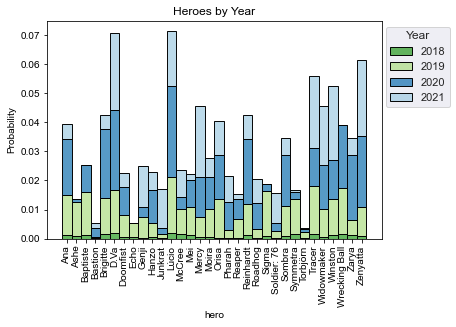

In [13]:
# Creates a histogram with probability for each character. 
# Data is the dataset used, hue selects the categories for the legend, multiple selects how the bars aligned.
# Check seaborn documentation for more information.

hero_freq = sns.histplot(
    data = merge_all_hero_sort,
    x = "hero",
    hue = "year",
    multiple = "stack",
    stat = "probability",
    palette="Paired",
    legend = True
)
sns.set(style = "darkgrid")
hero_freq.set_title("Heroes by Year")
hero_freq.legend(title = "Year", loc = "upper right", labels = ["2018", "2019","2020", "2021"], bbox_to_anchor= (1.22, 1))
plt.xticks(rotation = 90)
hero_freq.figure.savefig("plots/hero_probability_by_year_stacked.png", dpi = 300, bbox_inches = "tight")
plt.show()

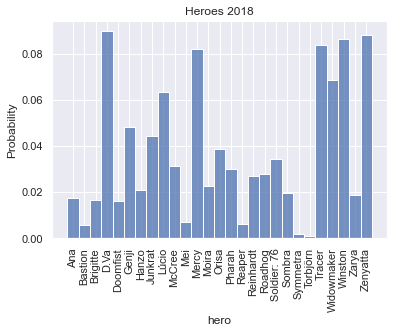

In [14]:
hero_2018 = sns.histplot(
    data = sorted_2018,
    x = "hero",
    stat = "probability",
)

hero_2018.set_title("Heroes 2018")
sns.set(style = "darkgrid")
plt.xticks(rotation = 90)
hero_2018.figure.savefig("plots/hero2018.png", dpi = 300, bbox_inches = "tight")
plt.show()

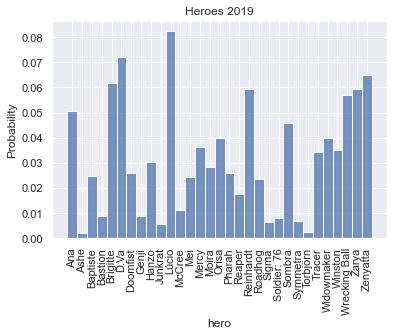

In [15]:
hero_2019 = sns.histplot(
    data = sorted_2019,
    x = "hero",
    stat = "probability",
    element = "bars"
)

hero_2019.set_title("Heroes 2019")
sns.set(style = "darkgrid")
plt.xticks(rotation = 90)
hero_2019.figure.savefig("plots/hero2019.png", dpi = 300, bbox_inches = "tight")
plt.show()

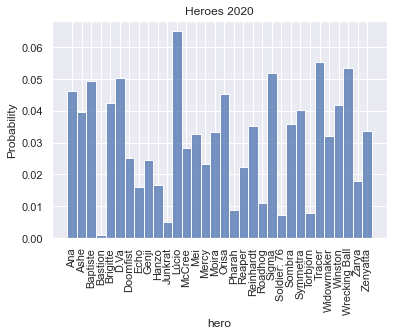

In [16]:
hero_2020 = sns.histplot(
    data = sorted_2020,
    x = "hero",
    stat = "probability",
    element = "bars"
)
hero_2020.set_title("Heroes 2020")
sns.set(style = "darkgrid")
plt.xticks(rotation = 90)
hero_2020.figure.savefig("plots/hero2020.png", dpi = 300, bbox_inches = "tight")
plt.show()

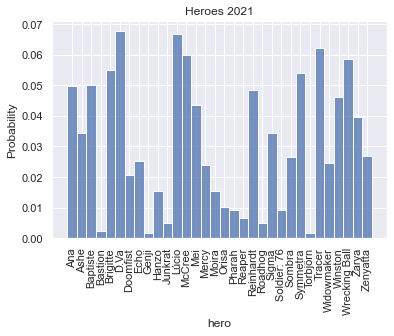

In [17]:
hero_2021 = sns.histplot(
    data = sorted_2021,
    x = "hero",
    stat = "probability",
    element = "bars"
)
hero_2021.set_title("Heroes 2021")
sns.set(style = "darkgrid")
plt.xticks(rotation = 90)
hero_2021.figure.savefig("plots/hero2021.png", dpi = 300, bbox_inches = "tight")
plt.show()

In [18]:
# Ensure everything is grouped properly and save it to a CSV

grouped = merge_all.groupby(["match_id", "map_name","team","player","hero", "map_win", "match_win", "year"]).count()
grouped.to_csv("filteredData/grouped.csv")

In [19]:
# Reads the previously saved CSV and converts it to a list of lists
data = pd.read_csv("filteredData/grouped.csv")
dataList = data.values.tolist()
dataList[0]

[10223,
 'Dorado',
 'Los Angeles Valiant',
 'Agilities',
 'Genji',
 'win',
 'win',
 2018.0]

## Create Data Frame for Team Compositions as Lists

In [20]:
# Creates a new DF with column titles
comps = pd.DataFrame(columns = ['match_id',"map_name",'team_name','team_comp','match_win','map_win', 'year'])
comps

,match_id,map_name,team_name,team_comp,match_win,map_win,year


In [21]:
# Convert dataList into dataframe which contains lists for team compositions
# Indices - [0 = match_id, 1 = map, 2 = teamName, 3 = Player Name, 4 = Hero, 5 = match_win, 6 = map_win, 7 = year]

match_id = dataList[0][0]

map_name = dataList[0][1]
team_name = dataList[0][2]

team_comp= [dataList[0][4]]
match_winner = dataList[0][5]
map_winner = dataList[0][6]
year = dataList[0][7]

# Gets the previous line and current line.
# Checks if the match_id, map, and teams match.
# If they do match, append the hero to the team comp list
# Else, the team has changed, and we want to append the data for the previous 
# composition to the dataframe.

for i in range(1,len(dataList)):
    prevLine = dataList[i-1]
    line = dataList[i]

    if(prevLine[0] == line[0] and prevLine[1] == line[1] and prevLine[2] == line[2]):
        team_comp.append(line[4]) 
    else:
        #sort alphabetically
        team_comp = sorted(team_comp)

        #create a dictionary entry for the team
        df2 = {"match_id" : match_id, "map_name": map_name ,"team_name": team_name, "team_comp" : team_comp, "match_win": match_winner, "map_win" : map_winner, "year" : year}

        #append it to the dataframe
        comps = comps.append(df2, ignore_index = True)

        #reset values to the current line
        match_id = line[0]
        map_name = line[1]
        team_name = line[2]
        team_comp = [line[4]]
        match_winner = line[5]
        map_winner = line[6]
        year = line[7]

In [22]:
# Saves the dataframe as a joblib file (object serialization)
# Many dataframes are saved and loaded for use multiple times in their original format.

dump(comps, "dataframes/teamCompsDF.joblib")
comps

,match_id,map_name,team_name,team_comp,match_win,map_win,year
0,10223,Dorado,Los Angeles Valiant,"[D.Va, Genji, Mercy, Tracer, Widowmaker, Winst...",win,win,2018.0
1,10223,Dorado,San Francisco Shock,"[D.Va, Genji, Junkrat, McCree, Mercy, Tracer, ...",lose,lose,2018.0
2,10223,Ilios,Los Angeles Valiant,"[D.Va, Genji, Lúcio, McCree, Mercy, Pharah, So...",win,win,2018.0
3,10223,Ilios,San Francisco Shock,"[D.Va, Lúcio, McCree, Mercy, Pharah, Soldier: ...",lose,lose,2018.0
4,10223,Numbani,Los Angeles Valiant,"[Bastion, D.Va, Lúcio, Mercy, Soldier: 76, Tra...",win,win,2018.0
...,...,...,...,...,...,...,...
7432,37256,Dorado,Guangzhou Charge,"[Ana, Ashe, Brigitte, Symmetra, Tracer, Winsto...",lose,lose,2021.0
7433,37256,Dorado,Shanghai Dragons,"[Ashe, D.Va, Mercy, Sigma, Tracer, Winston, Ze...",win,win,2021.0
7434,37256,Lijiang Tower,Guangzhou Charge,"[Ashe, Baptiste, Brigitte, D.Va, Doomfist, Ech...",lose,lose,2021.0
7435,37256,Lijiang Tower,Shanghai Dragons,"[Ashe, Baptiste, Brigitte, D.Va, Echo, Lúcio, ...",win,win,2021.0


## Create a "target vector" that's going to be passed into the encoder.

The results for each map are based off of "team 1", so I use both teams as "team1" to give the classifers another vector to train with. Therefore "targetVectors" DF contains two entries for each round. The "singleTargetVector" does not swap team1 and only has 1 entry for each round.

In [23]:
comps.to_csv("filteredData/comps_list.csv", index = False)
compsList = comps.values.tolist()

targetVectors = pd.DataFrame(columns = ['match_id','team1_comp', 'team2_comp','match_win','map_win'])
targetVectors

,match_id,team1_comp,team2_comp,match_win,map_win


In [24]:
singleTargetVector = pd.DataFrame(columns = ['match_id','team1_comp', 'team2_comp','match_win','map_win'])

In [25]:
# Gets current and next row, converts info into dictionary form to append to DF
for i in range(0, len(compsList)-1, 2):
    row1 = compsList[i]
    row2 = compsList[i+1]

    tv1 = {'match_id' : row1[0], 'team1_comp' : row1[3], 'team2_comp': row2[3], 'match_win': row1[4], 'map_win' : row1[5]}
    tv2 = {'match_id' : row1[0], 'team1_comp' : row2[3], 'team2_comp': row1[3],  'match_win': row2[4], 'map_win' : row2[5]}

    targetVectors = targetVectors.append(tv1, ignore_index= True)
    targetVectors = targetVectors.append(tv2, ignore_index = True)
    singleTargetVector = singleTargetVector.append(tv1, ignore_index = True)

targetVectors

,match_id,team1_comp,team2_comp,match_win,map_win
0,10223,"[D.Va, Genji, Mercy, Tracer, Widowmaker, Winst...","[D.Va, Genji, Junkrat, McCree, Mercy, Tracer, ...",win,win
1,10223,"[D.Va, Genji, Junkrat, McCree, Mercy, Tracer, ...","[D.Va, Genji, Mercy, Tracer, Widowmaker, Winst...",lose,lose
2,10223,"[D.Va, Genji, Lúcio, McCree, Mercy, Pharah, So...","[D.Va, Lúcio, McCree, Mercy, Pharah, Soldier: ...",win,win
3,10223,"[D.Va, Lúcio, McCree, Mercy, Pharah, Soldier: ...","[D.Va, Genji, Lúcio, McCree, Mercy, Pharah, So...",lose,lose
4,10223,"[Bastion, D.Va, Lúcio, Mercy, Soldier: 76, Tra...","[Ana, D.Va, Genji, McCree, Mercy, Soldier: 76,...",win,win
...,...,...,...,...,...
7431,37256,"[Ana, Ashe, Brigitte, D.Va, McCree, Mercy, Sig...","[Ana, Ashe, Brigitte, Lúcio, Sombra, Symmetra,...",lose,win
7432,37256,"[Ana, Ashe, Brigitte, Symmetra, Tracer, Winsto...","[Ashe, D.Va, Mercy, Sigma, Tracer, Winston, Ze...",lose,lose
7433,37256,"[Ashe, D.Va, Mercy, Sigma, Tracer, Winston, Ze...","[Ana, Ashe, Brigitte, Symmetra, Tracer, Winsto...",win,win
7434,37256,"[Ashe, Baptiste, Brigitte, D.Va, Doomfist, Ech...","[Ashe, Baptiste, Brigitte, D.Va, Echo, Lúcio, ...",lose,lose


In [26]:
dump(targetVectors, "dataframes/double.joblib")

['dataframes/double.joblib']

In [27]:
singleTargetVector
dump(singleTargetVector, "dataframes/single.joblib")

['dataframes/single.joblib']

In [28]:
# Creates a data frame for team and map without composition

teamWins = pd.DataFrame(columns = ['match_id', 'map', 'team1', 'team2','match_win','map_win'])
for i in range(0, len(compsList)-1, 2):
    row1 = compsList[i]
    row2 = compsList[i+1]

    tv1 = {'match_id' : row1[0], 'map' : row1[1] , 'team1' : row1[2], 'team2': row2[2], 'match_win': row1[4], 'map_win' : row1[5]}
    tv2 = {'match_id' : row1[0], 'map' : row2[1],'team1' : row2[2], 'team2': row1[2],  'match_win': row2[4], 'map_win' : row2[5]}

    teamWins = teamWins.append(tv1, ignore_index= True)
    teamWins = teamWins.append(tv2, ignore_index = True)

teamWins["map_result"] = np.where(teamWins["map_win"] == 'win', 1 , 0)
dump(teamWins, "dataframes/teamWins.joblib")
teamWins

,match_id,map,team1,team2,match_win,map_win,map_result
0,10223,Dorado,Los Angeles Valiant,San Francisco Shock,win,win,1
1,10223,Dorado,San Francisco Shock,Los Angeles Valiant,lose,lose,0
2,10223,Ilios,Los Angeles Valiant,San Francisco Shock,win,win,1
3,10223,Ilios,San Francisco Shock,Los Angeles Valiant,lose,lose,0
4,10223,Numbani,Los Angeles Valiant,San Francisco Shock,win,win,1
...,...,...,...,...,...,...,...
7431,37256,Blizzard World,Shanghai Dragons,Guangzhou Charge,lose,win,1
7432,37256,Dorado,Guangzhou Charge,Shanghai Dragons,lose,lose,0
7433,37256,Dorado,Shanghai Dragons,Guangzhou Charge,win,win,1
7434,37256,Lijiang Tower,Guangzhou Charge,Shanghai Dragons,lose,lose,0


In [29]:
# Creates a target vector for team comp and map for encoder
TVMaps = pd.DataFrame(columns = ['match_id', 'map', 'team1_comp', 'team2_comp','match_win','map_win'])
for i in range(0, len(compsList)-1, 2):
    row1 = compsList[i]
    row2 = compsList[i+1]

    tv1 = {'match_id' : row1[0], 'map' : row1[1] ,'team1_comp' : row1[3], 'team2_comp': row2[3], 'match_win': row1[4], 'map_win' : row1[5]}
    tv2 = {'match_id' : row1[0], 'map' : row2[1],'team1_comp' : row2[3], 'team2_comp': row1[3],  'match_win': row2[4], 'map_win' : row2[5]}

    TVMaps = TVMaps.append(tv1, ignore_index= True)
    TVMaps = TVMaps.append(tv2, ignore_index = True)

dump(TVMaps, "dataframes/double_maps.joblib")
TVMaps

,match_id,map,team1_comp,team2_comp,match_win,map_win
0,10223,Dorado,"[D.Va, Genji, Mercy, Tracer, Widowmaker, Winst...","[D.Va, Genji, Junkrat, McCree, Mercy, Tracer, ...",win,win
1,10223,Dorado,"[D.Va, Genji, Junkrat, McCree, Mercy, Tracer, ...","[D.Va, Genji, Mercy, Tracer, Widowmaker, Winst...",lose,lose
2,10223,Ilios,"[D.Va, Genji, Lúcio, McCree, Mercy, Pharah, So...","[D.Va, Lúcio, McCree, Mercy, Pharah, Soldier: ...",win,win
3,10223,Ilios,"[D.Va, Lúcio, McCree, Mercy, Pharah, Soldier: ...","[D.Va, Genji, Lúcio, McCree, Mercy, Pharah, So...",lose,lose
4,10223,Numbani,"[Bastion, D.Va, Lúcio, Mercy, Soldier: 76, Tra...","[Ana, D.Va, Genji, McCree, Mercy, Soldier: 76,...",win,win
...,...,...,...,...,...,...
7431,37256,Blizzard World,"[Ana, Ashe, Brigitte, D.Va, McCree, Mercy, Sig...","[Ana, Ashe, Brigitte, Lúcio, Sombra, Symmetra,...",lose,win
7432,37256,Dorado,"[Ana, Ashe, Brigitte, Symmetra, Tracer, Winsto...","[Ashe, D.Va, Mercy, Sigma, Tracer, Winston, Ze...",lose,lose
7433,37256,Dorado,"[Ashe, D.Va, Mercy, Sigma, Tracer, Winston, Ze...","[Ana, Ashe, Brigitte, Symmetra, Tracer, Winsto...",win,win
7434,37256,Lijiang Tower,"[Ashe, Baptiste, Brigitte, D.Va, Doomfist, Ech...","[Ashe, Baptiste, Brigitte, D.Va, Echo, Lúcio, ...",lose,lose


In [30]:
# Load a copy of the dataframe so I don't change the original.

teamWins = load("dataframes/teamWins.joblib")
teamWins.drop(["match_win", "map_win"], axis = 1, inplace = True)
teamWins.sort_values(by = ["team1", "team2"], inplace = True)

teamWins

,match_id,map,team1,team2,map_result
3186,21293,Busan,Atlanta Reign,Boston Uprising,0
3188,21293,Eichenwalde,Atlanta Reign,Boston Uprising,0
3190,21293,Lijiang Tower,Atlanta Reign,Boston Uprising,0
3192,21293,Temple of Anubis,Atlanta Reign,Boston Uprising,0
3194,21293,Watchpoint: Gibraltar,Atlanta Reign,Boston Uprising,0
...,...,...,...,...,...
7093,35534,Volskaya Industries,Washington Justice,Vancouver Titans,1
7239,37219,Blizzard World,Washington Justice,Vancouver Titans,1
7241,37219,Dorado,Washington Justice,Vancouver Titans,1
7243,37219,Lijiang Tower,Washington Justice,Vancouver Titans,1


In [31]:
# Finds the total maps/game played
# If I were to do this again, I would probably make a function
# that accepts a dataframe and column names, since I do this mulitple times
# to caclulate winning percentages.  

team_win_percentage = load("dataframes/teamWins.joblib")

# The counts here and in the future tell me that if grouped by the given column,
# here's how many games/maps that occured.

counts = team_win_percentage.groupby(["team1"], as_index = False).count()
counts

,team1,match_id,map,team2,match_win,map_win,map_result
0,Atlanta Reign,262,262,262,262,262,262
1,Boston Uprising,421,421,421,421,421,421
2,Chengdu Hunters,246,246,246,246,246,246
3,Dallas Fuel,407,407,407,407,407,407
4,Florida Mayhem,409,409,409,409,409,409
5,Guangzhou Charge,249,249,249,249,249,249
6,Hangzhou Spark,261,261,261,261,261,261
7,Houston Outlaws,421,421,421,421,421,421
8,London Spitfire,449,449,449,449,449,449
9,Los Angeles Gladiators,458,458,458,458,458,458


In [32]:
# Find total games/maps won
team_win_percentage = team_win_percentage.groupby(["team1", "map_result"], as_index = False).count()
team_win_percentage = team_win_percentage[team_win_percentage["map_result"] == 1]
team_win_percentage

,team1,map_result,match_id,map,team2,match_win,map_win
1,Atlanta Reign,1,119,119,119,119,119
3,Boston Uprising,1,175,175,175,175,175
5,Chengdu Hunters,1,102,102,102,102,102
7,Dallas Fuel,1,141,141,141,141,141
9,Florida Mayhem,1,132,132,132,132,132
11,Guangzhou Charge,1,142,142,142,142,142
13,Hangzhou Spark,1,139,139,139,139,139
15,Houston Outlaws,1,174,174,174,174,174
17,London Spitfire,1,228,228,228,228,228
19,Los Angeles Gladiators,1,253,253,253,253,253


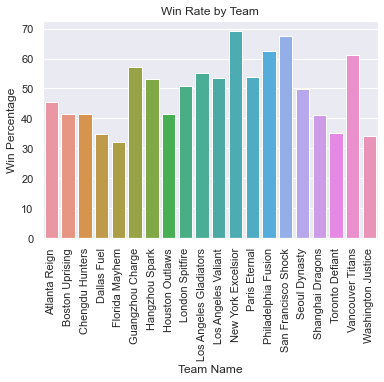

In [33]:
# Merge the two on team1 to find the win percentage
team_win_stats = pd.merge(team_win_percentage, counts, how = "left", on = ["team1"])
team_win_stats = team_win_stats.filter(["team1", "map_x", "map_y"])
team_win_stats["win_percentage"] = team_win_stats["map_x"] / team_win_stats["map_y"] * 100

team_wins = sns.barplot(
    data = team_win_stats,
    x = "team1",
    y = "win_percentage"
)

team_wins.set_title("Win Rate by Team")
team_wins.set(ylabel = "Win Percentage", xlabel = "Team Name")
team_wins.set_xticklabels(team_wins.get_xticklabels(), rotation = 90)
team_wins.figure.savefig("plots/team_winrate.png", dpi = 300, bbox_inches = "tight")
plt.show()

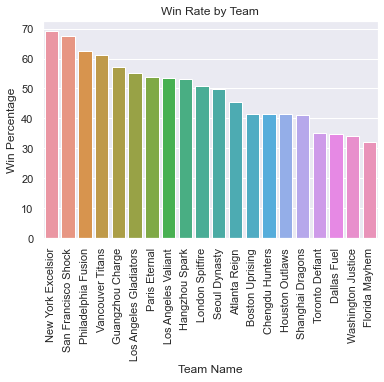

In [34]:
team_win_stats = team_win_stats.sort_values(by = "win_percentage", ascending = False)
team_wins = sns.barplot(
    data = team_win_stats,
    x = "team1",
    y = "win_percentage"
)
team_wins.set_title("Win Rate by Team")
team_wins.set(ylabel = "Win Percentage", xlabel = "Team Name")
team_wins.set_xticklabels(team_wins.get_xticklabels(), rotation = 90)
team_wins.figure.savefig("plots/team_winrate.png", dpi = 300, bbox_inches = "tight")
plt.show()

## Creating heat maps

In [35]:
# Creates a list of all the teams
team1 = teamWins["team1"].unique().tolist()
team1

['Atlanta Reign',
 'Boston Uprising',
 'Chengdu Hunters',
 'Dallas Fuel',
 'Florida Mayhem',
 'Guangzhou Charge',
 'Hangzhou Spark',
 'Houston Outlaws',
 'London Spitfire',
 'Los Angeles Gladiators',
 'Los Angeles Valiant',
 'New York Excelsior',
 'Paris Eternal',
 'Philadelphia Fusion',
 'San Francisco Shock',
 'Seoul Dynasty',
 'Shanghai Dragons',
 'Toronto Defiant',
 'Vancouver Titans',
 'Washington Justice']

In [36]:
team_maps = load("dataframes/teamWins.joblib")
team_maps = team_maps.filter(["team1", "team2", "map", "map_result"])
team_maps = team_maps.groupby(["team1", "map"], as_index = False).count()
team_maps

,team1,map,team2,map_result
0,Atlanta Reign,Blizzard World,8,8
1,Atlanta Reign,Busan,25,25
2,Atlanta Reign,Dorado,9,9
3,Atlanta Reign,Eichenwalde,10,10
4,Atlanta Reign,Hanamura,15,15
...,...,...,...,...
415,Washington Justice,Rialto,7,7
416,Washington Justice,Route 66,8,8
417,Washington Justice,Temple of Anubis,18,18
418,Washington Justice,Volskaya Industries,18,18


In [37]:
team_win_maps = load("dataframes/teamWins.joblib")
team_win_maps = team_win_maps.filter(["team1", "team2","map", "map_result"])
team_win_maps = team_win_maps.groupby(["team1", "map","map_result"], as_index = False).count()
team_win_maps = team_win_maps[team_win_maps["map_result"] ==  1]
team_win_maps

,team1,map,map_result,team2
1,Atlanta Reign,Blizzard World,1,4
3,Atlanta Reign,Busan,1,10
5,Atlanta Reign,Dorado,1,3
7,Atlanta Reign,Eichenwalde,1,5
9,Atlanta Reign,Hanamura,1,6
...,...,...,...,...
825,Washington Justice,Rialto,1,2
827,Washington Justice,Route 66,1,2
829,Washington Justice,Temple of Anubis,1,8
831,Washington Justice,Volskaya Industries,1,7


In [38]:
#merges the wins and total maps
team_win_stats = pd.merge(team_win_maps, team_maps, how = "left", on = ["team1", "map"] )
team_win_stats["map_winrate"] = team_win_stats["team2_x"]/team_win_stats["team2_y"] * 100
team_win_stats = team_win_stats.filter(["team1", "map", "map_winrate"])

#pivots teams stats so that team1 is the index and the columns are the map
team_win_stats = team_win_stats.pivot(index = "team1", columns= "map", values = "map_winrate")
team_win_stats = team_win_stats.fillna(0)
team_win_stats

map,Blizzard World,Busan,Dorado,Eichenwalde,Hanamura,Havana,Hollywood,Horizon Lunar Colony,Ilios,Junkertown,...,Lijiang Tower,Nepal,Numbani,Oasis,Paris,Rialto,Route 66,Temple of Anubis,Volskaya Industries,Watchpoint: Gibraltar
team1,,,,,,,,,,,,,,,,,,,,,
Atlanta Reign,50.000000,40.000000,33.333333,50.000000,40.000000,50.000000,50.000000,66.666667,42.857143,42.857143,...,58.333333,25.000000,41.666667,45.454545,25.000000,45.454545,66.666667,56.250000,33.333333,45.454545
Boston Uprising,57.894737,26.666667,52.380952,35.294118,22.222222,0.000000,26.666667,37.500000,53.571429,52.631579,...,43.750000,54.166667,57.894737,40.625000,0.000000,25.000000,61.111111,52.000000,60.869565,25.000000
Chengdu Hunters,42.857143,38.888889,50.000000,54.545455,40.000000,44.444444,23.076923,40.000000,29.411765,22.222222,...,41.176471,64.285714,45.454545,42.857143,22.222222,62.500000,25.000000,53.846154,41.176471,41.666667
Dallas Fuel,31.578947,33.333333,41.176471,56.250000,23.076923,33.333333,21.428571,41.176471,24.000000,16.666667,...,37.037037,33.333333,28.571429,48.000000,50.000000,55.555556,33.333333,32.000000,44.000000,33.333333
Florida Mayhem,36.363636,42.105263,18.750000,18.750000,46.428571,41.666667,38.888889,6.250000,37.500000,30.434783,...,25.000000,41.666667,31.818182,13.636364,40.000000,12.500000,44.444444,28.571429,34.615385,33.333333
Guangzhou Charge,60.000000,52.631579,42.857143,57.142857,75.000000,50.000000,57.142857,66.666667,72.222222,57.142857,...,44.444444,61.538462,42.857143,58.333333,12.500000,58.333333,42.857143,57.142857,68.750000,66.666667
Hangzhou Spark,66.666667,61.904762,41.666667,64.285714,41.666667,57.142857,53.846154,60.000000,58.823529,50.000000,...,50.000000,60.000000,60.000000,50.000000,62.500000,50.000000,60.000000,57.894737,41.176471,57.142857
Houston Outlaws,38.095238,43.750000,52.380952,43.750000,50.000000,70.000000,28.571429,62.500000,34.482759,27.777778,...,35.483871,36.000000,38.888889,43.333333,28.571429,45.454545,27.777778,40.909091,33.333333,50.000000
London Spitfire,47.619048,41.666667,78.260870,55.555556,60.000000,25.000000,50.000000,57.894737,41.176471,68.000000,...,58.064516,46.153846,60.869565,51.515152,50.000000,42.857143,42.857143,30.769231,48.148148,39.130435


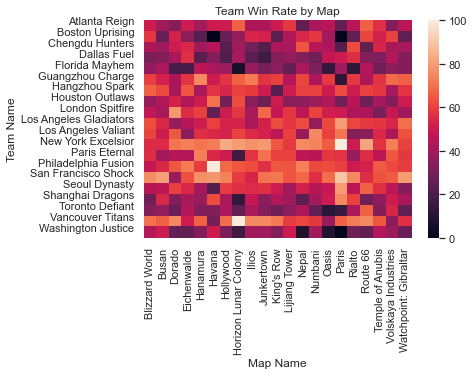

In [39]:
# Heat map for team1 per map
teamVmap = sns.heatmap(
    data = team_win_stats
)
teamVmap.set_title("Team Win Rate by Map")
teamVmap.set_yticks(range(0,20))
teamVmap.set_yticklabels(team1)
teamVmap.set_ylabel("Team Name")
teamVmap.set_xlabel("Map Name")
teamVmap.figure.savefig("plots/team_v_map_heatmap.png", dpi = 300, bbox_inches = "tight")
plt.show()

In [40]:
# Team vs team win rate 
team_wins = load("dataframes/teamWins.joblib")
team_wins = team_wins.sort_values(by = ["team1", "team2"])
team_wins = team_wins.filter(["team1", "team2", "map_result"])
team_wins = team_wins.groupby(["team1", "team2"], as_index = False).mean()
dump(team_wins, "dataframes/team_v_team.joblib")

# Pivot values to create matrix
team_wins_unsorted = team_wins.pivot(index = ["team1"], columns = ["team2"],  values = ["map_result"])
team_wins_unsorted = team_wins_unsorted.fillna(0)
team_wins_unsorted

map_result                                  \
team2                  Atlanta Reign Boston Uprising Chengdu Hunters   
team1                                                                  
Atlanta Reign               0.000000        0.750000        0.000000   
Boston Uprising             0.250000        0.000000        0.000000   
Chengdu Hunters             1.000000        1.000000        0.000000   
Dallas Fuel                 0.000000        0.379310        0.000000   
Florida Mayhem              0.620690        0.322581        0.000000   
Guangzhou Charge            1.000000        1.000000        0.764706   
Hangzhou Spark              0.500000        1.000000        0.888889   
Houston Outlaws             0.000000        0.512195        0.000000   
London Spitfire             0.500000        0.615385        0.352941   
Los Angeles Gladiators      1.000000        0.212121        1.000000   
Los Angeles Valiant         0.769231        0.517241        0.692308   
New York Excelsior          0.400000        0.718750        0.600000   
Paris Eternal               0.409091        0.736842        0.000000   
Philadelphia Fusion         1.000000        0.704545        0.444444   
San Francisco Shock         0.708333        0.761905        0.444444   
Seoul Dynasty               1.000000        0.250000        0.578947   
Shanghai Dragons            1.000000        0.250000        0.769231   
Toronto Defiant             0.370370        0.705882        1.000000   
Vancouver Titans            0.571429        1.000000        0.692308   
Washington Justice          0.000000        1.000000        0.000000   

                                                                    \
team2                  Dallas Fuel Florida Mayhem Guangzhou Charge   
team1                                                                
Atlanta Reign             1.000000       0.379310         0.000000   
Boston Uprising           0.620690       0.677419         0.000000   
Chengdu Hunters           1.000000       1.000000         0.235294   
Dallas Fuel               0.000000       0.380952         0.000000   
Florida Mayhem            0.619048       0.000000         0.000000   
Guangzhou Charge          1.000000       1.000000         0.000000   
Hangzhou Spark            1.000000       1.000000         0.357143   
Houston Outlaws           0.485714       0.675676         0.000000   
London Spitfire           0.750000       0.862069         0.333333   
Los Angeles Gladiators    0.657143       0.625000         1.000000   
Los Angeles Valiant       0.606061       0.882353         0.500000   
New York Excelsior        1.000000       1.000000         0.483871   
Paris Eternal             0.733333       0.727273         1.000000   
Philadelphia Fusion       0.703704       0.750000         0.000000   
San Francisco Shock       0.900000       0.838710         1.000000   
Seoul Dynasty             0.840000       1.000000         0.538462   
Shanghai Dragons          0.000000       0.235294         0.615385   
Toronto Defiant           0.000000       0.000000         0.000000   
Vancouver Titans          0.823529       0.266667         0.750000   
Washington Justice        0.318182       0.650000         0.000000   

                                                                       \
team2                  Hangzhou Spark Houston Outlaws London Spitfire   
team1                                                                   
Atlanta Reign                0.500000        1.000000        0.500000   
Boston Uprising              0.000000        0.487805        0.384615   
Chengdu Hunters              0.111111        1.000000        0.647059   
Dallas Fuel                  0.000000        0.514286        0.250000   
Florida Mayhem               0.000000        0.324324        0.137931   
Guangzhou Charge             0.642857        1.000000        0.666667   
Hangzhou Spark               0.000000        0.000000        0.588235   
Houston Outlaws             

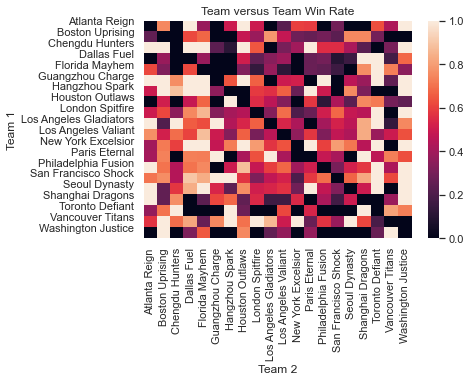

In [41]:
# Heat map team1 versus team2
heat_map = sns.heatmap(
    data = team_wins_unsorted
)
heat_map.set_title("Team versus Team Win Rate")
heat_map.set_yticks(range(0,20))
heat_map.set_yticklabels(team1)
heat_map.set_xticklabels(team1)
heat_map.set(ylabel = "Team 1", xlabel = "Team 2")
heat_map.figure.savefig("plots/team_v_team_heatmap.png", dpi = 300, bbox_inches = "tight")
plt.show()

## Start plotting by team composition

In [42]:
comps_tuple = load("dataframes/teamCompsDF.joblib")
comps_tuple['comp_size'] = comps_tuple['team_comp'].apply(lambda x: len(x))
comps_tuple['team_comp'] = comps_tuple['team_comp'].apply(lambda x: tuple(x))
dump(comps_tuple, "dataframes/comps_tuple.joblib")

# normal team size, no changes
comps_6 = comps_tuple[comps_tuple['comp_size'] == 6]

# one hero change
comps_7 = comps_tuple[comps_tuple['comp_size'] == 7]

In [43]:
comps_tuple.groupby(["team_comp"]).count()

,match_id,map_name,team_name,match_win,map_win,year,comp_size
team_comp,,,,,,,
"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va, Doomfist, Echo, Lúcio, Moira, Orisa, Reaper, Reinhardt, Sigma, Symmetra, Tracer, Winston)",1,1,1,1,1,1,1
"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va, Doomfist, Genji, Hanzo, Lúcio, Mercy, Orisa, Pharah, Reinhardt, Soldier: 76, Sombra, Tracer, Widowmaker, Winston, Wrecking Ball, Zarya)",1,1,1,1,1,1,1
"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va, Doomfist, Hanzo, Lúcio, Mercy, Moira, Pharah, Reinhardt, Sombra, Torbjörn, Tracer, Widowmaker, Winston, Wrecking Ball, Zarya, Zenyatta)",1,1,1,1,1,1,1
"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va, Genji, Hanzo, Lúcio, Mercy, Orisa, Pharah, Reinhardt, Sombra, Tracer, Widowmaker, Winston, Wrecking Ball, Zarya, Zenyatta)",1,1,1,1,1,1,1
"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va, Junkrat, Lúcio, Mercy, Orisa, Pharah, Reinhardt, Sombra, Widowmaker, Wrecking Ball, Zarya, Zenyatta)",1,1,1,1,1,1,1
...,...,...,...,...,...,...,...
"(Lúcio, Moira, Reaper, Reinhardt, Sombra, Symmetra, Zarya)",3,3,3,3,3,3,3
"(Lúcio, Moira, Reaper, Reinhardt, Sombra, Widowmaker, Zarya)",1,1,1,1,1,1,1
"(Lúcio, Moira, Sombra, Symmetra, Tracer, Winston, Zarya)",1,1,1,1,1,1,1


In [44]:
# Changes single target vector lists to tuple
comp_v_comp = load("dataframes/single.joblib")
comp_v_comp['team1_comp'] = comp_v_comp['team1_comp'].apply(lambda x: tuple(x))
comp_v_comp['team2_comp'] = comp_v_comp['team2_comp'].apply(lambda x: tuple(x))

In [45]:
#Checks for mirror comps
mirror_comps = comp_v_comp[comp_v_comp['team1_comp'] == comp_v_comp['team2_comp']]
mirror_comps.drop(["match_win"], axis = 1)
mirror_comps["map_result"] = np.where(mirror_comps["map_win"] == 'win', 1 , 0)
mirror_comps

<ipython-input-45-b8dea582a2d6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mirror_comps["map_result"] = np.where(mirror_comps["map_win"] == 'win', 1 , 0)


,match_id,team1_comp,team2_comp,match_win,map_win,map_result
20,10227,"(D.Va, Lúcio, Mercy, Pharah, Tracer, Winston)","(D.Va, Lúcio, Mercy, Pharah, Tracer, Winston)",lose,lose,0
36,10231,"(Ana, D.Va, Mercy, Pharah, Soldier: 76, Tracer...","(Ana, D.Va, Mercy, Pharah, Soldier: 76, Tracer...",win,win,1
41,10233,"(D.Va, Lúcio, McCree, Mercy, Tracer, Widowmake...","(D.Va, Lúcio, McCree, Mercy, Tracer, Widowmake...",lose,lose,0
46,10234,"(D.Va, Lúcio, Mercy, Pharah, Soldier: 76, Trac...","(D.Va, Lúcio, Mercy, Pharah, Soldier: 76, Trac...",lose,lose,0
79,10242,"(D.Va, Lúcio, McCree, Mercy, Tracer, Widowmake...","(D.Va, Lúcio, McCree, Mercy, Tracer, Widowmake...",win,win,1
...,...,...,...,...,...,...
3231,34762,"(Ana, Ashe, D.Va, Mercy, Sombra, Symmetra, Wid...","(Ana, Ashe, D.Va, Mercy, Sombra, Symmetra, Wid...",win,win,1
3431,34892,"(Ana, Brigitte, Genji, Sombra, Winston, Zarya)","(Ana, Brigitte, Genji, Sombra, Winston, Zarya)",lose,win,1
3586,35546,"(D.Va, Lúcio, Moira, Reaper, Sombra, Winston)","(D.Va, Lúcio, Moira, Reaper, Sombra, Winston)",win,win,1
3591,35547,"(D.Va, Lúcio, Moira, Reaper, Sombra, Winston)","(D.Va, Lúcio, Moira, Reaper, Sombra, Winston)",lose,lose,0


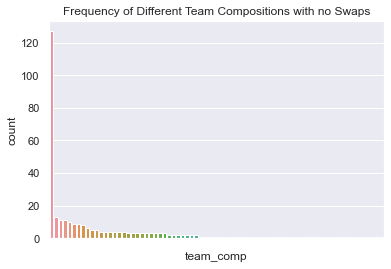

In [46]:
#Frequency of certain comps for no swaps
comp_plot = sns.countplot(
    x = "team_comp",
    data = comps_6,
    order = comps_6['team_comp'].value_counts().index
)
sns.set_style("darkgrid")
comp_plot.set_title("Frequency of Different Team Compositions with no Swaps")
comp_plot.set(xticklabels = [])
comp_plot.figure.savefig("plots/comp6_plot.png", dpi = 300, bbox_inches = "tight")
plt.show()

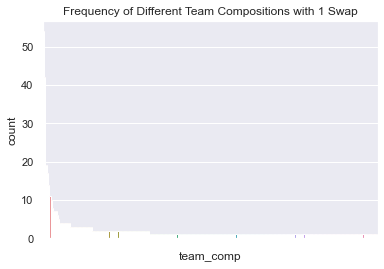

In [47]:
#Frequency of certain comps for no swaps
comp_plot = sns.countplot(
    x = "team_comp",
    data = comps_7,
    order = comps_7['team_comp'].value_counts().index
)
sns.set_style("darkgrid")
comp_plot.set_title("Frequency of Different Team Compositions with 1 Swap")
comp_plot.set(xticklabels = [])
comp_plot.figure.savefig("plots/comp7_plot.png", dpi = 300, bbox_inches = "tight")
plt.show()

In [48]:
comps_tuple.describe()
# Average comp size is 11, median is 11, so that means they swapped characters on average 5 times

,year,comp_size
count,7437.000000,7437.000000
mean,2019.062122,11.089552
std,0.841636,3.118822
min,2018.000000,6.000000
25%,2018.000000,9.000000
50%,2019.000000,11.000000
75%,2020.000000,13.000000
max,2021.000000,24.000000


In [49]:
# Checking if the median is the same as the mean or if data is skewed.
comps_tuple.median()

match_id     21356.0
year          2019.0
comp_size       11.0
dtype: float64

In [50]:
percentage = comps_tuple.groupby(["team_comp", "map_win"]).count()
percentage["usage_percent"] = percentage["match_id"]/comps_tuple["match_id"].count()*100

In [51]:
#Calculating how much each team is used
percentage.sort_values(by = ["usage_percent"], ascending = False)

# Divide the team comps counts to get frequency
percentage = comps_6.groupby(["team_comp"], as_index = False).count()
percentage["usage_percent"] = percentage["match_id"]/comps_6["match_id"].count()*100
percentage.sort_values(by = ["usage_percent"], ascending = False)

,team_comp,match_id,map_name,team_name,match_win,map_win,year,comp_size,usage_percent
46,"(Brigitte, D.Va, Lúcio, Reinhardt, Zarya, Zeny...",127,127,127,127,127,127,127,39.6875
72,"(Doomfist, Lúcio, Moira, Orisa, Reaper, Sigma)",13,13,13,13,13,13,13,4.0625
54,"(Brigitte, Lúcio, Reinhardt, Sombra, Zarya, Ze...",11,11,11,11,11,11,11,3.4375
71,"(D.Va, Mercy, Tracer, Widowmaker, Winston, Zen...",11,11,11,11,11,11,11,3.4375
13,"(Ana, D.Va, Lúcio, McCree, Mei, Reinhardt)",10,10,10,10,10,10,10,3.1250
...,...,...,...,...,...,...,...,...,...
38,"(Baptiste, Lúcio, Mei, Reinhardt, Sigma, Symme...",1,1,1,1,1,1,1,0.3125
39,"(Baptiste, Mei, Orisa, Roadhog, Widowmaker, Ze...",1,1,1,1,1,1,1,0.3125
40,"(Baptiste, Orisa, Sigma, Sombra, Widowmaker, Z...",1,1,1,1,1,1,1,0.3125
41,"(Baptiste, Orisa, Sigma, Tracer, Widowmaker, Z...",1,1,1,1,1,1,1,0.3125


## Calculating win rate per team composition

I tried plotting this, but it takes a long time and does not look good, so I removed it.

In [52]:
maps_used = load("dataframes/comps_tuple.joblib")
maps_used = maps_used.groupby(["team_comp", "comp_size", "map_win"], as_index = False).count()
maps_used["num_maps"] = maps_used["match_id"]
maps_used = maps_used.filter(["team_comp", "map_win", "comp_size", "num_maps"])
maps_used

,team_comp,map_win,comp_size,num_maps
0,"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va,...",lose,17,1
1,"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va,...",lose,21,1
2,"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va,...",win,21,1
3,"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va,...",win,20,1
4,"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va,...",lose,17,1
...,...,...,...,...
6356,"(Lúcio, Moira, Reaper, Reinhardt, Sombra, Symm...",win,7,2
6357,"(Lúcio, Moira, Reaper, Reinhardt, Sombra, Wido...",win,7,1
6358,"(Lúcio, Moira, Sombra, Symmetra, Tracer, Winst...",win,7,1
6359,"(Lúcio, Moira, Sombra, Tracer, Winston, Wrecki...",win,7,1


In [53]:
wins = maps_used.copy()
wins = wins[wins["map_win"] == "win"]
wins.rename(columns = {"num_maps" : "num_wins"}, inplace = True)
wins.drop(columns = "map_win", inplace = True)
wins

,team_comp,comp_size,num_wins
2,"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va,...",21,1
3,"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va,...",20,1
5,"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va,...",14,1
7,"(Ana, Ashe, Baptiste, Bastion, Brigitte, Genji...",11,1
10,"(Ana, Ashe, Baptiste, Bastion, McCree, Mercy, ...",11,1
...,...,...,...
6356,"(Lúcio, Moira, Reaper, Reinhardt, Sombra, Symm...",7,2
6357,"(Lúcio, Moira, Reaper, Reinhardt, Sombra, Wido...",7,1
6358,"(Lúcio, Moira, Sombra, Symmetra, Tracer, Winst...",7,1
6359,"(Lúcio, Moira, Sombra, Tracer, Winston, Wrecki...",7,1


In [54]:
losses = maps_used.copy()
losses = losses[losses["map_win"] == "lose"]
losses.rename(columns = {"num_maps" : "num_losses"}, inplace = True)
losses.drop(columns = "map_win", inplace = True)
losses

,team_comp,comp_size,num_losses
0,"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va,...",17,1
1,"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va,...",21,1
4,"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va,...",17,1
6,"(Ana, Ashe, Baptiste, Bastion, Brigitte, Genji...",17,1
8,"(Ana, Ashe, Baptiste, Bastion, Hanzo, Lúcio, M...",15,1
...,...,...,...
6341,"(Lúcio, McCree, Mei, Moira, Reinhardt, Tracer,...",7,1
6342,"(Lúcio, McCree, Mercy, Pharah, Reinhardt, Wido...",8,1
6353,"(Lúcio, Moira, Reaper, Reinhardt, Roadhog, Som...",8,1
6354,"(Lúcio, Moira, Reaper, Reinhardt, Sombra, Symm...",8,1


## Calculating win rate per comp size/hero swaps

In [55]:
maps_used_comp_size = load("dataframes/comps_tuple.joblib")
maps_used_comp_size = maps_used_comp_size.groupby(["comp_size", "map_win"], as_index = False).count()
maps_used_comp_size["num_maps"] = maps_used_comp_size["match_id"]
maps_used_comp_size = maps_used_comp_size.filter(["map_win", "comp_size", "num_maps"])

In [56]:
# Gets number of wins on maps used
wins = maps_used_comp_size.copy()
wins = wins[wins["map_win"] == "win"]
wins.rename(columns = {"num_maps" : "num_wins"}, inplace = True)
wins.drop(columns = "map_win", inplace = True)

# Gets number of losses on maps used
losses = maps_used_comp_size.copy()
losses = losses[losses["map_win"] == "lose"]
losses.rename(columns = {"num_maps" : "num_losses"}, inplace = True)
losses.drop(columns = "map_win", inplace = True)

# Finds the win rate in percent by (wins)/(wins + losses) * 100
winrate_size = pd.merge(wins, losses, how = "left", on = ["comp_size"])
winrate_size.fillna(0, inplace = True)
winrate_size["winrate"] = (winrate_size["num_wins"] / (winrate_size["num_wins"] + winrate_size["num_losses"])) * 100
winrate_size

,comp_size,num_wins,num_losses,winrate
0,6,185,135,57.812500
1,7,319,239,57.168459
2,8,465,368,55.822329
3,9,466,410,53.196347
4,10,460,466,49.676026
5,11,379,453,45.552885
6,12,390,396,49.618321
7,13,336,361,48.206600
8,14,240,309,43.715847
9,15,169,182,48.148148


In [57]:
# Converts comp size to number of character swaps
# Base team size is 6
winrate_size["character_swaps"] = winrate_size["comp_size"] - 6
winrate_size

,comp_size,num_wins,num_losses,winrate,character_swaps
0,6,185,135,57.812500,0
1,7,319,239,57.168459,1
2,8,465,368,55.822329,2
3,9,466,410,53.196347,3
4,10,460,466,49.676026,4
5,11,379,453,45.552885,5
6,12,390,396,49.618321,6
7,13,336,361,48.206600,7
8,14,240,309,43.715847,8
9,15,169,182,48.148148,9


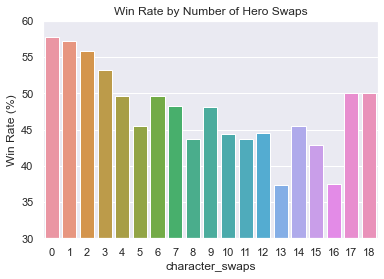

In [58]:
winrate_percent = sns.barplot(
    data = winrate_size,
    x = "character_swaps",
    y = "winrate",
   
)
winrate_percent.set_title("Win Rate by Number of Hero Swaps")
winrate_percent.set_ylabel("Win Rate (%)")
sns.set_style("darkgrid")
plt.ylim(30,60)
winrate_percent.figure.savefig("plots/winrate_by_swaps.png", dpi = 300)
plt.show()

In [59]:
winrate_size["total_games"] = winrate_size["num_wins"] + winrate_size["num_losses"] 
winrate_size

,comp_size,num_wins,num_losses,winrate,character_swaps,total_games
0,6,185,135,57.812500,0,320
1,7,319,239,57.168459,1,558
2,8,465,368,55.822329,2,833
3,9,466,410,53.196347,3,876
4,10,460,466,49.676026,4,926
5,11,379,453,45.552885,5,832
6,12,390,396,49.618321,6,786
7,13,336,361,48.206600,7,697
8,14,240,309,43.715847,8,549
9,15,169,182,48.148148,9,351


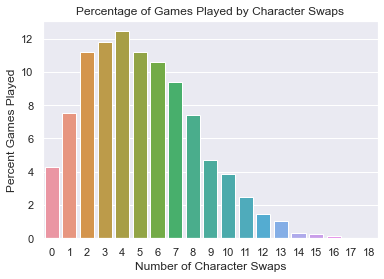

In [60]:
winrate_size["percent_games_played"] = winrate_size["total_games"] / winrate_size["total_games"].sum() * 100
games_by_numsize_percent = sns.barplot(
    data = winrate_size,
    x = "character_swaps",
    y = "percent_games_played"
)
games_by_numsize_percent.set_title("Percentage of Games Played by Character Swaps")
games_by_numsize_percent.set_ylabel("Percent Games Played")
games_by_numsize_percent.set_xlabel("Number of Character Swaps")
games_by_numsize_percent.figure.savefig("plots/games_played_char_swaps.png", dpi = 300)
plt.show()

## Encode with MultiLabelBinarizer

In [61]:
targetVectors.to_csv("filteredData/comps.csv", index = False)
df = load("dataframes/double.joblib")
df

,match_id,team1_comp,team2_comp,match_win,map_win
0,10223,"[D.Va, Genji, Mercy, Tracer, Widowmaker, Winst...","[D.Va, Genji, Junkrat, McCree, Mercy, Tracer, ...",win,win
1,10223,"[D.Va, Genji, Junkrat, McCree, Mercy, Tracer, ...","[D.Va, Genji, Mercy, Tracer, Widowmaker, Winst...",lose,lose
2,10223,"[D.Va, Genji, Lúcio, McCree, Mercy, Pharah, So...","[D.Va, Lúcio, McCree, Mercy, Pharah, Soldier: ...",win,win
3,10223,"[D.Va, Lúcio, McCree, Mercy, Pharah, Soldier: ...","[D.Va, Genji, Lúcio, McCree, Mercy, Pharah, So...",lose,lose
4,10223,"[Bastion, D.Va, Lúcio, Mercy, Soldier: 76, Tra...","[Ana, D.Va, Genji, McCree, Mercy, Soldier: 76,...",win,win
...,...,...,...,...,...
7431,37256,"[Ana, Ashe, Brigitte, D.Va, McCree, Mercy, Sig...","[Ana, Ashe, Brigitte, Lúcio, Sombra, Symmetra,...",lose,win
7432,37256,"[Ana, Ashe, Brigitte, Symmetra, Tracer, Winsto...","[Ashe, D.Va, Mercy, Sigma, Tracer, Winston, Ze...",lose,lose
7433,37256,"[Ashe, D.Va, Mercy, Sigma, Tracer, Winston, Ze...","[Ana, Ashe, Brigitte, Symmetra, Tracer, Winsto...",win,win
7434,37256,"[Ashe, Baptiste, Brigitte, D.Va, Doomfist, Ech...","[Ashe, Baptiste, Brigitte, D.Va, Echo, Lúcio, ...",lose,lose


In [62]:
# Loads the MLB,
# Pops "team1_comp" out of the DF,
# fits and transforms the MLB on the "team1_comp" column
# and appends it back to the original DF with the new columns as the classes from the MLB

mlb = MultiLabelBinarizer()
df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('team1_comp')), columns = mlb.classes_, index=df.index))

In [63]:
# Transforms "team2_comp" in the way stated above based on the fit from team1
# Suffix is added to differntiate team1 from team2 in DF hero columns

df = df.join(pd.DataFrame(mlb.transform(df.pop('team2_comp')), columns = mlb.classes_, index=df.index), rsuffix= '_2')

In [64]:
df.to_csv("filteredData/MultiLabelBinarizer.csv", index  = False)
dump(df, "dataframes/mlb_DF.joblib")
df

,match_id,match_win,map_win,Ana,Ashe,Baptiste,Bastion,Brigitte,D.Va,Doomfist,...,Soldier: 76_2,Sombra_2,Symmetra_2,Torbjörn_2,Tracer_2,Widowmaker_2,Winston_2,Wrecking Ball_2,Zarya_2,Zenyatta_2
0,10223,win,win,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,1
1,10223,lose,lose,0,0,0,0,0,1,0,...,0,0,0,0,1,1,1,0,0,1
2,10223,win,win,0,0,0,0,0,1,0,...,1,0,0,0,1,1,1,0,0,1
3,10223,lose,lose,0,0,0,0,0,1,0,...,1,0,0,0,1,1,1,0,0,1
4,10223,win,win,0,0,0,1,0,1,0,...,1,0,0,0,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7431,37256,lose,win,1,1,0,0,1,1,0,...,0,1,1,0,1,0,1,1,1,0
7432,37256,lose,lose,1,1,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,1
7433,37256,win,win,0,1,0,0,0,1,0,...,0,0,1,0,1,0,1,0,1,0
7434,37256,lose,lose,0,1,1,0,1,1,1,...,0,1,1,0,1,0,0,1,0,1


In [65]:
dump(mlb, "models/mlb.joblib")

['models/mlb.joblib']

In [66]:
map_wins_by_char = load("dataframes/mlb_DF.joblib")
map_wins_by_char = map_wins_by_char[map_wins_by_char["map_win"] == "win"]
map_wins_by_char = map_wins_by_char.groupby(["map_win"]).mean()

In [67]:
map_wins_by_char = map_wins_by_char.iloc[:, 0:32]

In [68]:
percents = map_wins_by_char.multiply(100, axis = 0)

In [69]:
percents

,Ana,Ashe,Baptiste,Bastion,Brigitte,D.Va,Doomfist,Echo,Genji,Hanzo,...,Soldier: 76,Sombra,Symmetra,Torbjörn,Tracer,Widowmaker,Winston,Wrecking Ball,Zarya,Zenyatta
map_win,,,,,,,,,,,,,,,,,,,,,
win,43.045467,14.743072,27.979553,5.407587,47.027172,77.374227,23.513586,5.757331,28.167877,26.015604,...,15.308044,37.47646,19.531881,3.820285,59.026096,51.466236,57.465698,38.633306,37.933818,68.523002


Text(0.5, 0, 'Hero')

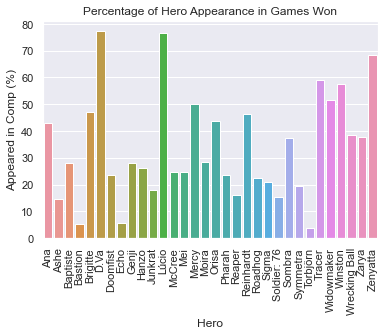

In [70]:
#Plots the character usage for winning team compositions only
character_wins = sns.barplot(
    data = percents
)
character_wins.set_title("Percentage of Hero Appearance in Games Won")
character_wins.set_xticklabels(character_wins.get_xticklabels(), rotation = 90)
character_wins.set_ylabel("Appeared in Comp (%)")
character_wins.set_xlabel("Hero")

In [71]:
character_wins.figure.savefig("plots/games_won_by_hero.png", bbox_inches = "tight", dpi = 300)
plt.show()

In [72]:
#MLB for maps included
df2 = load("dataframes/double_maps.joblib")
df2 = df2.values.tolist()
df2[0]

[10223,
 'Dorado',
 ['D.Va', 'Genji', 'Mercy', 'Tracer', 'Widowmaker', 'Winston', 'Zenyatta'],
 ['D.Va',
  'Genji',
  'Junkrat',
  'McCree',
  'Mercy',
  'Tracer',
  'Winston',
  'Zenyatta'],
 'win',
 'win']

In [73]:
teams_with_map = pd.DataFrame(columns = ["team1", "team2", "map_result"])
teams_with_map

,team1,team2,map_result


In [74]:
# Puts the map in with the team compisition list in order to be fit the same way on the MLB

for i in range(len(df2)):
    row = df2[i]

    map_name = [row[1]]
    team1 = row[2]
    team2 = row[3]
    map_result = row[5]

    newComp1 = map_name + team1
    newComp2 = map_name + team2

    vect = {"team1" : newComp1, "team2": newComp2, "map_result": map_result }
    teams_with_map = teams_with_map.append(vect, ignore_index = True)

teams_with_map

,team1,team2,map_result
0,"[Dorado, D.Va, Genji, Mercy, Tracer, Widowmake...","[Dorado, D.Va, Genji, Junkrat, McCree, Mercy, ...",win
1,"[Dorado, D.Va, Genji, Junkrat, McCree, Mercy, ...","[Dorado, D.Va, Genji, Mercy, Tracer, Widowmake...",lose
2,"[Ilios, D.Va, Genji, Lúcio, McCree, Mercy, Pha...","[Ilios, D.Va, Lúcio, McCree, Mercy, Pharah, So...",win
3,"[Ilios, D.Va, Lúcio, McCree, Mercy, Pharah, So...","[Ilios, D.Va, Genji, Lúcio, McCree, Mercy, Pha...",lose
4,"[Numbani, Bastion, D.Va, Lúcio, Mercy, Soldier...","[Numbani, Ana, D.Va, Genji, McCree, Mercy, Sol...",win
...,...,...,...
7431,"[Blizzard World, Ana, Ashe, Brigitte, D.Va, Mc...","[Blizzard World, Ana, Ashe, Brigitte, Lúcio, S...",win
7432,"[Dorado, Ana, Ashe, Brigitte, Symmetra, Tracer...","[Dorado, Ashe, D.Va, Mercy, Sigma, Tracer, Win...",lose
7433,"[Dorado, Ashe, D.Va, Mercy, Sigma, Tracer, Win...","[Dorado, Ana, Ashe, Brigitte, Symmetra, Tracer...",win
7434,"[Lijiang Tower, Ashe, Baptiste, Brigitte, D.Va...","[Lijiang Tower, Ashe, Baptiste, Brigitte, D.Va...",lose


In [75]:
mlb2 = MultiLabelBinarizer()
teams_with_map = teams_with_map.join(pd.DataFrame(mlb2.fit_transform(teams_with_map.pop('team1')), columns = mlb2.classes_, index=teams_with_map.index))

In [76]:
teams_with_map = teams_with_map.join(pd.DataFrame(mlb2.transform(teams_with_map.pop('team2')), columns = mlb2.classes_, index=teams_with_map.index), rsuffix= '_2')
teams_with_map

,map_result,Ana,Ashe,Baptiste,Bastion,Blizzard World,Brigitte,Busan,D.Va,Doomfist,...,Temple of Anubis_2,Torbjörn_2,Tracer_2,Volskaya Industries_2,Watchpoint: Gibraltar_2,Widowmaker_2,Winston_2,Wrecking Ball_2,Zarya_2,Zenyatta_2
0,win,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,1
1,lose,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,1,0,0,1
2,win,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,1,0,0,1
3,lose,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,1,0,0,1
4,win,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7431,win,1,1,0,0,1,1,0,1,0,...,0,0,1,0,0,0,1,1,1,0
7432,lose,1,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1
7433,win,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,1,0
7434,lose,0,1,1,0,0,1,0,1,1,...,0,0,1,0,0,0,0,1,0,1


In [77]:
dump(mlb2, "models/mlb-map.joblib")

['models/mlb-map.joblib']

In [78]:
teams_with_map.to_csv("filteredData/MultiLabelBinarizer2.csv", index  = False)